### Transfer Learning using ResNet-18

#### 1. Problem Statement

The goal of this project is to build a multi-classifier using pre-trained ResNet-18 model for vegetable classification. In this Notebook, we visualize the results of the trained model along with feature maps.

#### 2. Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import itertools

%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-rxd2cags
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-rxd2cags
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4991 sha256=779da0b8ac5690e75fa597994a1e359c84f8ed04f7549da57fb5b556a9c9bfe3
  Stored in directory: /tmp/pip-ephem-wheel-cache-v52ndg5e/wheels/69/06/fd/652908d49c931cdcca96be3c727fb11ed777a3a62402210396
Successfully built torchviz


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision import models

from sklearn.metrics import *

#### 3. Define Hyperparameters

In [ ]:
num_classes = 15

batch_size = 128

num_epochs = 101

learning_rate = 1e-2

weight_decay = 5e-4

device = 'cuda'

root = '/'

img_size = 224

#### 4. Define Dataset Class

PyTorch Dataset class builds the data in a tuple and gives us access to each index.

In [ ]:
data_augmentation_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop((img_size, img_size)),
    transforms.RandomErasing(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)
])

data_augmentation_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size))
])

In [ ]:
def get_img_path_label_list(root, mode):
    img_path_list = []
    img_label_list = []
    sub_folders = next(os.walk(os.path.join(root, mode)))[1]
    
    for i in sub_folders:
        sub_img_path = list(glob.glob(os.path.join(root, mode, i, '*.jpg')))
        count = 0
        for j in sub_img_path:
            if mode == 'train':
                if count < 300:
                    img_path_list.append(j)
                    img_label_list.append(i)
                    count += 1
            else:
                if count < 50:
                    img_path_list.append(j)
                    img_label_list.append(i)
                    count += 1
    
    img_label_one_hot_list = {}
    for i in range(len(sub_folders)):
        img_label_one_hot_list[sub_folders[i]] = i

    return img_path_list, img_label_list, img_label_one_hot_list

In [ ]:
class Vegetable(Dataset):
    def __init__(self, root, mode, aug):
        assert mode in ['train', 'validation', 'test']

        self.root = root
        self.mode = mode
        self.aug = aug

        self.img_path, self.img_label, self.img_label_one_hot = get_img_path_label_list(root, mode)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])

        img = self.aug(img)
        img = img.float()

        label = self.img_label[index]

        label_one_hot = self.img_label_one_hot[label]
        
        return img, label, label_one_hot

    def __len__(self):
        length = len(self.img_path)
        
        return length

#### 5. Build Dataset

In [ ]:
def get_dataset(root, mode, aug):
    assert mode in ['train', 'validation', 'test']
    return Vegetable(root, mode, aug)

#### 6. Build Dataloader

In [ ]:
def get_dataloader(root, mode, batch_size, aug):
    assert mode in ['train', 'validation', 'test']
    
    shuffle = True
    num_workers = 2
    
    dataset = get_dataset(root, mode, aug)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return dataloader

#### 7. Load Data Sets

In [ ]:
train_loader = get_dataloader(root, 'train', batch_size, data_augmentation_train)
val_loader = get_dataloader(root, 'validation', batch_size, data_augmentation_test)
test_loader = get_dataloader(root, 'test', batch_size, data_augmentation_test)

#### 8. Visualize Training Data

The shape of a batch of images: torch.Size([128, 3, 224, 224])


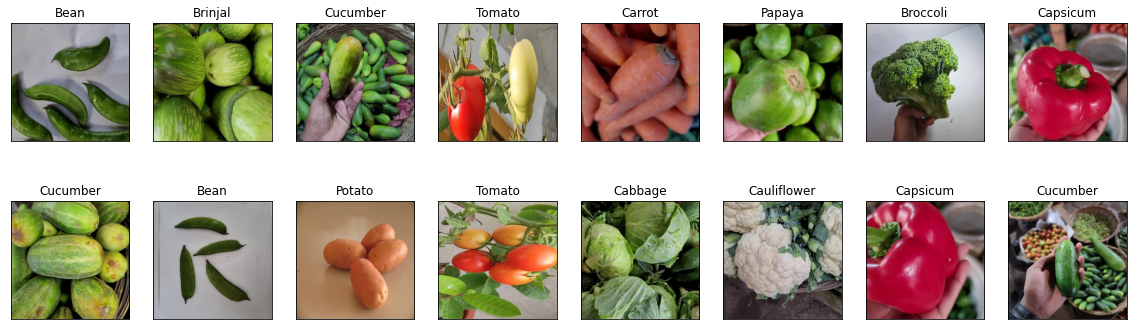

In [ ]:
for images, labels, labels_one_hot in test_loader:
    print(f'The shape of a batch of images: {images.shape}')

    labels_print = labels[: 16]
    images_print = torch.permute(images[: 16], (0, 2, 3, 1)).detach().numpy()
    
    _, axs = plt.subplots(2, 8, figsize=(20, 6))
    axs = axs.flatten()

    i = 0
    for img, ax in zip(images_print, axs):
        ax.set_title(labels[i])

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(img)
        i += 1
    plt.show()
    break

#### 9. Build DNN Model

Define the layers, neurons, and activation function.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=15):
        super(ResNet, self).__init__()
        net = models.resnet18(pretrained=True)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
                nn.Linear(1000, 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
net = ResNet(num_classes=num_classes).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#### 10. Load the Trained Model

In [ ]:
net = torch.load('/Transfer-ResNet-18.pth')

#### 11. Output Distribution Analysis

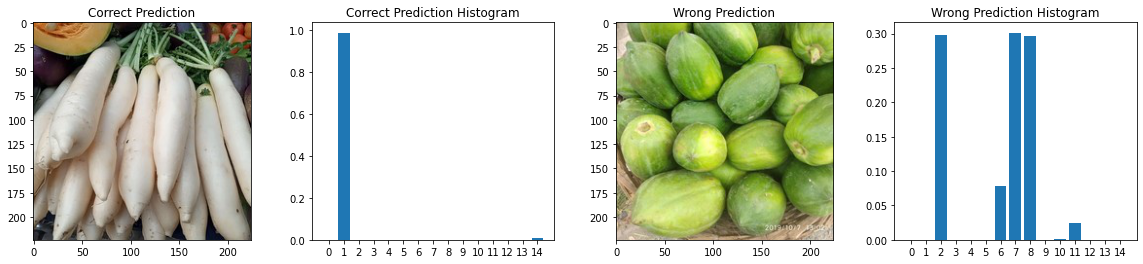

In [ ]:
from scipy.special import softmax

net.eval()
with torch.no_grad():
    for features, labels, labels_one_hot in test_loader:
        features, labels_one_hot = features.to(device), labels_one_hot.to(device)

        pred_test = net(features)
        pred_print = torch.max(pred_test, 1)[1].cpu().numpy()

        label_print = labels_one_hot.cpu().numpy()
        feature_print = torch.permute(features, (0, 2, 3, 1)).detach().cpu().numpy()
        feature_print = np.squeeze(feature_print)

        _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

        count = 0
        for i in range(len(pred_print)):
            if pred_print[i] == label_print[i] and count != 0:
                ax1.imshow(feature_print[i])
                ax1.set_title('Correct Prediction')
                ax2.bar([str(t) for t in range(15)], softmax(pred_test[i].cpu().numpy()))
                ax2.set_title('Correct Prediction Histogram')
                count += 1
            if pred_print[i] != label_print[i]:
                ax3.imshow(feature_print[i])
                ax3.set_title('Wrong Prediction')
                ax4.bar([str(t) for t in range(15)], softmax(pred_test[i].cpu().numpy()))
                ax4.set_title('Wrong Prediction Histogram')
                count += 1
            if count == 2:
                break
        break

The histograms give us the Softmax probability to which the class the image belongs. For the correct prediction, the Softmax probability of the true category is much higher than the probabilities of other categories. On the other hand, the wrong prediction has multiple Softmax probabilities that have similar values.